BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [ ]:
def wrangle(path):
  df = pd.read_csv(path).set_index('resultId')
  #df.drop(columns=['positionText','milliseconds','positionOrder','number','laps','fastestLap'],inplace=True)
  df.drop(columns=['positionText','positionOrder','points'],inplace=True)
  cutoff = 100
  drop_cols =[col for col in df.select_dtypes('object').columns if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace = True)
  df.fillna(0,inplace=True)
  df = df[df.statusId==1]
  #df['change_pos'] = df['position'] - df['grid']
  return df

In [ ]:
result = wrangle('results.csv')
result.isnull().mean()*100
result.head()

,raceId,driverId,constructorId,number,grid,position,laps,milliseconds,fastestLap,rank,statusId
resultId,,,,,,,,,,,
1,18,1,1,22.0,1,1.0,58,5690616.0,39.0,2.0,1
2,18,2,2,3.0,5,2.0,58,5696094.0,41.0,3.0,1
3,18,3,3,7.0,7,3.0,58,5698779.0,41.0,5.0,1
4,18,4,4,5.0,11,4.0,58,5707797.0,58.0,7.0,1
5,18,5,1,23.0,3,5.0,58,5708630.0,43.0,1.0,1


In [ ]:
target = 'position'
X = result.drop(target,axis=1)
y = result[target]

In [ ]:
X_remain,X_test,y_remain,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_remain,y_remain,test_size=.25,random_state = 42)

In [ ]:
baseline = y_train.value_counts(normalize=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = make_pipeline(
    SimpleImputer(), OrdinalEncoder(), RandomForestClassifier()
)
model.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
param_grid = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth':range(5,25,5),
    'randomforestclassifier__n_estimators':range(25,200,25)
}

model_1 = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_jobs = -1,
    cv=5,
    n_iter=25
)
model_1.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             mapping=[])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 25, 5),
                                        'randomforestclassifier__n_estimators': range(25, 200, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']})

In [ ]:
best_score = model_1.best_score_
best_params = model_1.best_params_

print(best_score,best_params)

0.2638002773925104 {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 75, 'randomforestclassifier__max_depth': 5}


In [ ]:
print(model_1.score(X_train,y_train))
print(model_1.score(X_val,y_val))

0.3509015256588072
0.2512479201331115


In [ ]:
#Now for XGBoost and GradientBoost
#first gradientboost
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42,n_estimators = 75)
)
model_gb.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=75, random_state=42))])

In [ ]:
print(model_gb.score(X_train,y_train))
print(model_gb.score(X_val,y_val))

0.5769764216366158
0.23294509151414308


In [ ]:
#Now XGBoost
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,n_estimator=75,n_jobs=-1)
)
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(n_estimator=75, n_jobs=-1,
                               objective='multi:softprob', random_state=42))])

In [ ]:
print(model_xgb.score(X_train,y_train))
print(model_xgb.score(X_val,y_val))
# Looks like I cant really predict final position from grid position but it was a good experiment

0.4416088765603329
0.24459234608985025


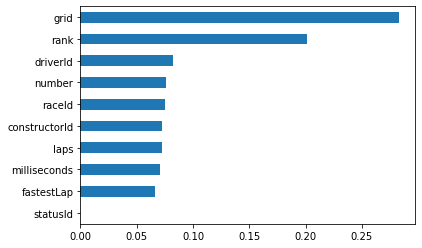

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')


In [ ]:
col = 'rank'
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])
print('validation accuracy', model_xgb.score(X_val,y_val))

validation accuracy 0.24459234608985025


In [ ]:
from sklearn.inspection import permutation_importance 
perm_imp = permutation_importance(model_xgb, X_val, y_val,random_state=42)


In [ ]:
perm_imp

{'importances': array([[ 0.00166389,  0.00748752,  0.        ,  0.00915141, -0.00249584],
        [ 0.00831947,  0.01081531, -0.00166389,  0.00582363,  0.00665557],
        [-0.00166389,  0.00748752,  0.00915141,  0.01331115, -0.00249584],
        [ 0.0124792 ,  0.0124792 ,  0.0124792 ,  0.00499168,  0.01830283],
        [ 0.09234609,  0.08818636,  0.08485857,  0.1031614 ,  0.09983361],
        [-0.00499168, -0.00332779, -0.00582363, -0.00665557, -0.00748752],
        [ 0.00166389, -0.00083195, -0.00249584, -0.00166389, -0.01081531],
        [-0.00166389,  0.00083195, -0.00083195, -0.00831947, -0.00415973],
        [ 0.03078203,  0.03327787,  0.00998336,  0.02911814,  0.03244592],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
 'importances_mean': array([ 0.0031614 ,  0.00599002,  0.00515807,  0.01214642,  0.0936772 ,
        -0.00565724, -0.00282862, -0.00282862,  0.02712146,  0.        ]),
 'importances_std': array([0.00444605, 0.00418958, 0.00621236, 0.

In [ ]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}


df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
laps,-0.005657,0.001431
milliseconds,-0.002829,0.004229
fastestLap,-0.002829,0.003183
statusId,0.000000,0.000000
raceId,0.003161,0.004446
constructorId,0.005158,0.006212
driverId,0.005990,0.004190
number,0.012146,0.004229
rank,0.027121,0.008687
grid,0.093677,0.006893
